This notebook compares Gaia DR3 astrophysical parameters to APOGEE, primarily focusing on [$\alpha$/Fe].

## Imports and definitions

In [91]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from astropy.table import Table

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

Utility functions

In [2]:
def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.
    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def scatter_hist(ax, x, y, xlim=None, ylim=None, log_norm=True, cmap='gray',
                 cmin=10, vmin=None, vmax=None, nbins=50, color='k', pad=True):
    """
    Generate a scatter plot and overlayed 2D histogram for dense data.

    Parameters
    ----------
    ax : matplotlib.axis.Axes
        Axes object on which to plot the data.
    x : array-like
        Horizontal coordinates of the data points.
    y : array-like
        Vertical coordinates of the data points.
    xlim : float, optional
        Bounds for x-axis. The default is None.
    ylim : float, optional
        Bounds for y-axis. The default is None.
    log_norm : bool, optional
        Shade the 2D histogram on a logarithmic scale. The default is True.
    cmap : str, optional
        Colormap for 2D histogram. The default is'gray'.
    cmin : int, optional
        Minimum counts per bin; any number below this will show individual points.
        The default is 10.
    vmin : float or None, optional
        Value to map to minimum of histogram normalization. The default is None.
    vmax : float or None, optional
        Value to map to maximum of histogram normalization. The default is None.
    nbins : int or tuple of ints, optional
        Number of histogram bins. If a tuple, presumed to be (xbins, ybins).
        The default is 50.
    color : str, optional
        Color of individual points. The default is 'k'.
    pad : bool, optional
        Whether to apply a small pad to the x- and y-axis limits. The default
        is True.

    Returns
    -------
    matplotlib.axis.Axes

    """
    # Set automatic plot bounds
    if not xlim:
        xlim = (np.min(x), np.max(x))
    if not ylim:
        ylim = (np.min(y), np.max(y))
    # Set bin edges
    if type(nbins) == 'tuple':
        xbins, ybins = nbins
    else:
        xbins = ybins = nbins
    xbins = np.linspace(xlim[0], xlim[1], num=xbins, endpoint=True)
    ybins = np.linspace(ylim[0], ylim[1], num=ybins, endpoint=True)
    # Histogram normalization
    if log_norm:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    ax.scatter(x, y, c=color, s=0.5)
    ax.hist2d(x, y, bins=[xbins, ybins], cmap=cmap, norm=norm, cmin=cmin)
    
    if pad:
        dx = 2*(xbins[1] - xbins[0])
        dy = 2*(ybins[1] - ybins[0])
        xlim = (xlim[0] - dx, xlim[1] + dx)
        ylim = (ylim[0] - dy, ylim[1] + dy)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

## Database stuff

Import ASPCAP allStar file and make some preliminary quality cuts.
Also remove any entries without a Gaia EDR3 source ID.

In [3]:
aspcap_path = Path('data/allStarLite-dr17-synspec.fits')
# Import APOGEE allStar data
aspcap_table = Table.read(aspcap_path, format='fits', hdu=1)
# Separate paramflags into individual columns
for i in range(len(aspcap_table['PARAMFLAG'][0])):
    aspcap_table['PARAMFLAG' + str(i)] = aspcap_table['PARAMFLAG'][:,i]
# Filter out multidimensional columns
cols = [name for name in aspcap_table.colnames if len(aspcap_table[name].shape) <= 1]
# Convert byte-strings to ordinary strings and convert to pandas
aspcap_df = decode(aspcap_table[cols].to_pandas())
# Drop duplicate targets, keeping highest adjusted SNR
aspcap_df = aspcap_df.sort_values(['APOGEE_ID', 'SNREV'])\
                     .drop_duplicates(subset='APOGEE_ID', keep='last')\
                     .sort_index()
# Replace NaN stand-in values with NaN
aspcap_df.replace(99.999, np.nan, inplace=True)
# Replace NaN in ASPCAPFLAGS with empty string
aspcap_df['ASPCAPFLAGS'].replace(np.nan, '', inplace=True)
# Replace '' with 'none' in columns of type 'object'
# aspcap_df.replace('', 'none', inplace=True)
# Remove VESTA
aspcap_df.drop(0, inplace=True)
# Weed out bad flags
fatal_flags = (2**23) # STAR_BAD
aspcap_df = aspcap_df[aspcap_df['ASPCAPFLAG'] & fatal_flags == 0]
# Copy 2Mass ID column without "2M" prefix
# also limit to targets with a 2Mass ID
# aspcap_df = aspcap_df[aspcap_df['APOGEE_ID'].str.contains('2M')
# aspcap_df['TMASS_ID'] = [id[2:] for id in aspcap_df.APOGEE_ID.tolist()]
# aspcap_df['TMASS_ID'].to_csv('data/apogee_tmass_ids.csv', index=False, header=False)

# Limit to targets with a Gaia EDR3 Source ID
aspcap_df = aspcap_df[aspcap_df['GAIAEDR3_SOURCE_ID'] != 0]
aspcap_df.reset_index(inplace=True, drop=True)

aspcap_df

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,CE_FE_FLAG,PARAMFLAG0,PARAMFLAG1,PARAMFLAG2,PARAMFLAG3,PARAMFLAG4,PARAMFLAG5,PARAMFLAG6,PARAMFLAG7,PARAMFLAG8
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,64,0,33554432,0,0,0,0,0,0,0
1,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,64,0,0,288,0,0,256,0,0,0
2,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,64,0,0,0,0,0,32,0,0,0
3,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,0,32,33554464,32,32,32,32,32,0,0
4,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,0,0,33554432,32,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613452,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0,0,33554464,0,0,32,32,32,0,0
613453,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0,0,16777216,0,0,0,0,0,0,0
613454,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,0,0,33554432,0,0,0,0,0,0,0
613455,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,0,0,33554464,0,0,32,32,32,0,0


Export a table of just APOGEE IDs and Gaia Source IDs.

In [4]:
apogee_gaia_ids = Table.from_pandas(aspcap_df[['APOGEE_ID', 'GAIAEDR3_SOURCE_ID']])
apogee_gaia_ids.write('data/apogee_gaia_ids.fits', overwrite=True)

Upload the above as a user table to the Gaia Archive. Then run the following ADQL query:

```
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, 
gaia.pm, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, 
gaia.radial_velocity, gaia.radial_velocity_error, 
gaia.phot_g_mean_mag, gaia.bp_rp, gaia.phot_variable_flag,
gaia.l, gaia.b, gaia.non_single_star, gaia.has_xp_continuous, gaia.has_xp_sampled, 
gaia.has_rvs, 
astro.teff_gspphot, astro.teff_gspphot_lower, astro.teff_gspphot_upper, 
astro.logg_gspphot, astro.logg_gspphot_lower, astro.logg_gspphot_upper, 
astro.mh_gspphot, astro.mh_gspphot_lower, astro.mh_gspphot_upper, 
astro.distance_gspphot, astro.distance_gspphot_lower, astro.distance_gspphot_upper, 
astro.ag_gspphot, astro.ag_gspphot_lower, astro.ag_gspphot_upper, 
astro.ebpminrp_gspphot, astro.ebpminrp_gspphot_lower, astro.ebpminrp_gspphot_upper,  astro.mg_gspphot, astro.mg_gspphot_lower, astro.mg_gspphot_upper, 
astro.teff_gspspec, astro.teff_gspspec_lower, astro.teff_gspspec_upper, 
astro.logg_gspspec, astro.logg_gspspec_lower, astro.logg_gspspec_upper, 
astro.mh_gspspec, astro.mh_gspspec_lower, astro.mh_gspspec_upper, 
astro.alphafe_gspspec, astro.alphafe_gspspec_lower, astro.alphafe_gspspec_upper,  
astro.sife_gspspec, astro.sife_gspspec_lower, astro.sife_gspspec_upper, 
astro.cafe_gspspec, astro.cafe_gspspec_lower, astro.cafe_gspspec_upper, 
astro.mgfe_gspspec, astro.mgfe_gspspec_lower, astro.mgfe_gspspec_upper, 
astro.flags_gspspec
FROM gaiadr3.gaia_source AS gaia
JOIN user_ldubay.apogee_gaia_ids AS u
	ON gaia.source_id=u.gaiaedr3_source_id
JOIN gaiadr3.astrophysical_parameters AS astro
	ON astro.source_id=gaia.source_id
```

If you don't care about download size and just want all the columns, replace everything after `SELECT` with `SELECT gaia.*, astro.*`.

Import the resulting table.

In [5]:
gaia_tab = Table.read('data/gaia_apogee_custom.fits.gz')
gaia_df = decode(gaia_tab.to_pandas())
gaia_df

,source_id,ra,dec,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,...,sife_gspspec,sife_gspspec_lower,sife_gspspec_upper,cafe_gspspec,cafe_gspspec_lower,cafe_gspspec_upper,mgfe_gspspec,mgfe_gspspec_lower,mgfe_gspspec_upper,flags_gspspec
0,538028216707715712,0.000205,74.285436,0.285442,0.019475,0.524503,0.048582,0.024032,0.522248,0.022098,...,NaN,NaN,NaN,0.23,0.20,0.26,NaN,NaN,NaN,00000001000009999999900990100999999991205
1,2413929812587459072,0.000970,-19.413922,0.082093,0.315081,22.773376,20.290023,0.302588,-10.341260,0.273871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000020000009999999999999999999999999999
2,422596679964513792,0.001332,57.619507,1.298531,0.009522,3.252581,-0.410274,0.008729,-3.226601,0.008972,...,NaN,NaN,NaN,0.11,0.02,0.21,NaN,NaN,NaN,00000010000009999999900999999999999999999
3,4689447878791422208,0.001481,-73.394323,-0.023941,0.045007,1.294620,0.255408,0.053589,-1.269176,0.055720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,421077597267551104,0.002913,57.173075,1.386356,0.017567,13.990686,5.791725,0.016173,-12.735589,0.015647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000010000009999999999999999999999999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613328,6379920759951899648,359.994489,-73.651150,0.057268,0.059721,1.540449,0.456376,0.070229,-1.471293,0.072737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613329,1998097371124974720,359.995268,57.434918,0.422966,0.019244,2.772645,-0.458060,0.017031,-2.734545,0.017039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613330,1994741318040223232,359.996716,56.163345,0.334590,0.015344,2.121073,-1.908003,0.013315,0.926537,0.013527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613331,6379914575198998272,359.997823,-73.716478,0.018227,0.069314,1.523327,0.453707,0.085933,-1.454193,0.082054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Join tables

In [6]:
alldata = aspcap_df.copy()
alldata = alldata.join(gaia_df.set_index('source_id'), on='GAIAEDR3_SOURCE_ID', how='inner')
# Drop small number of duplicates (not enough to worry about method)
alldata.drop_duplicates(subset='GAIAEDR3_SOURCE_ID', inplace=True)
alldata

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,sife_gspspec,sife_gspspec_lower,sife_gspspec_upper,cafe_gspspec,cafe_gspspec_lower,cafe_gspspec_upper,mgfe_gspspec,mgfe_gspspec_lower,mgfe_gspspec_upper,flags_gspspec
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,0.23,0.20,0.26,NaN,NaN,NaN,00000001000009999999900990100999999991205
1,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000020000009999999999999999999999999999
2,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,NaN,NaN,NaN,0.11,0.02,0.21,NaN,NaN,NaN,00000010000009999999900999999999999999999
3,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000010000009999999999999999999999999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613452,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613453,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613454,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613455,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calibrate [$\alpha$/Fe] from GSP-Spec according to Recio-Blanco et al. (2022):

In [74]:
logg_calib = lambda x: -0.5809 + 0.7018*x + -0.2402*x**2 + 0.0239*x**3
alldata["alphafe_gspspec_calib_logg"] = alldata["alphafe_gspspec"] + logg_calib(alldata["logg_gspspec"])

teff_calib = lambda t: -6.696 + 20.877*t + -21.0967*t**2 + 6.8313*t**3
alldata["alphafe_gspspec_calib_teff"] = alldata["alphafe_gspspec"] + teff_calib(alldata["teff_gspspec"]/5750)

## Plots

Gaia DR3 GSP-Phot parameters vs APOGEE DR17. Agreement is not very good, to say the least.

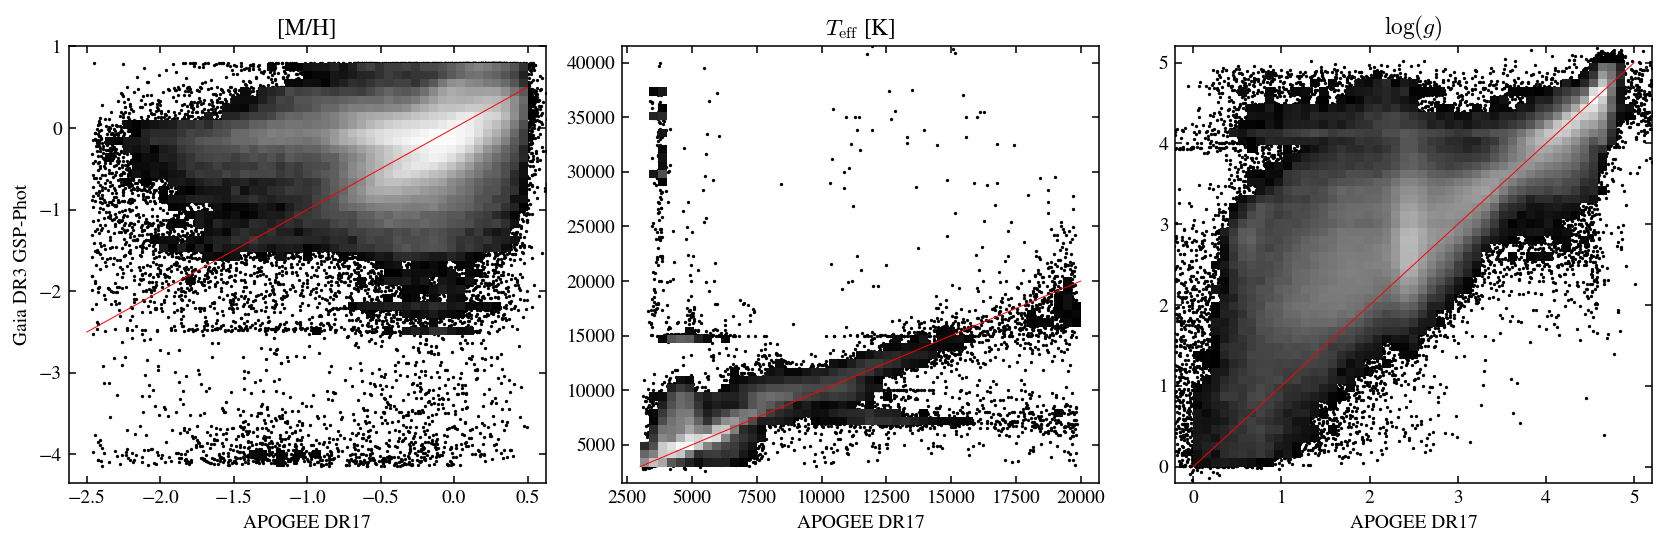

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

scatter_hist(axs[0], alldata["M_H"], alldata["mh_gspphot"], 
             xlim=(-2.5, 0.5))
axs[0].plot([-2.5, 0.5], [-2.5, 0.5], c='r', lw=0.5)
axs[0].set_xlabel("APOGEE DR17")
axs[0].set_ylabel("Gaia DR3 GSP-Phot")
axs[0].set_title("[M/H]")

scatter_hist(axs[1], alldata["TEFF"], alldata["teff_gspphot"], 
             xlim=(3000, 20000), ylim=(3000, 40000))
axs[1].plot([3000, 20000], [3000, 20000], c='r', lw=0.5)
axs[1].set_xlabel("APOGEE DR17")
axs[1].set_title(r"$T_{\rm{eff}}$ [K]")

scatter_hist(axs[2], alldata["LOGG"], alldata["logg_gspphot"], 
             xlim=(0, 5), ylim=(0, 5))
axs[2].plot([0, 5], [0, 5], c='r', lw=0.5)
axs[2].set_xlabel("APOGEE DR17")
axs[2].set_title(r"$\log(g)$")
plt.show()

Gaia DR3 GSP-Spec parameters vs APOGEE DR17. This has much better agreement with APOGEE, especially for $T_{\rm{eff}}\lesssim7000$ K. Unfortunately [$\alpha$/Fe] looks *terrible* in GSP-Spec, completely missing the bimodality in APOGEE. There are also a number of stars stuck at grid points, most notably at ($T_{\rm{eff}}=4250$ K, $\log(g)=1.5$).

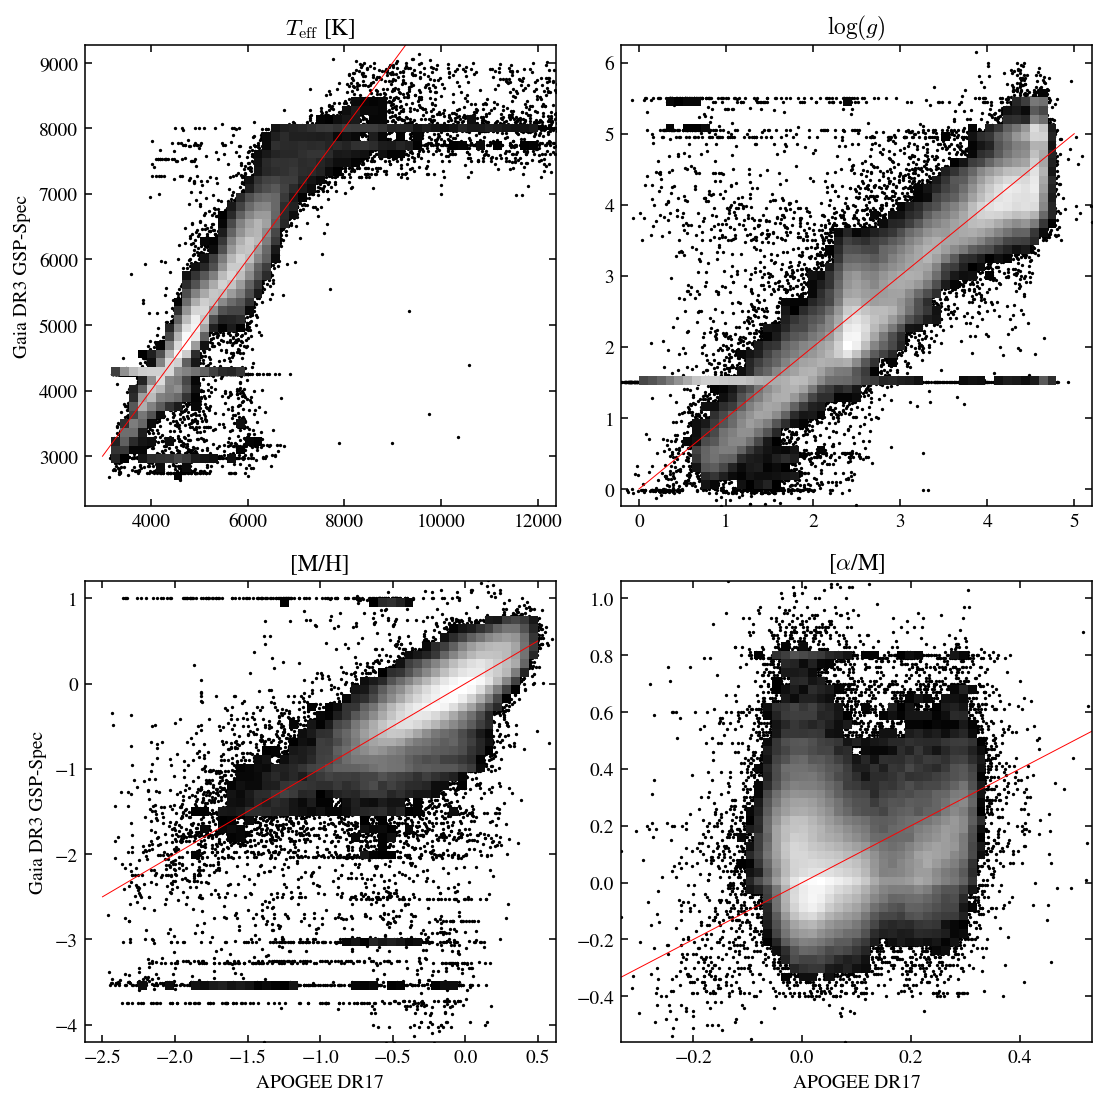

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

scatter_hist(axs[0,0], alldata["TEFF"], alldata["teff_gspspec"], 
             xlim=(3000, 12000), ylim=(2500, 9000))
axs[0,0].plot([3000, 10000], [3000, 10000], c='r', lw=0.5)
axs[0,0].set_title(r"$T_{\rm{eff}}$ [K]")
axs[0,0].set_ylabel("Gaia DR3 GSP-Spec")

scatter_hist(axs[0,1], alldata["LOGG"], alldata["logg_gspspec"], 
             xlim=(0, 5), ylim=(0, 6))
axs[0,1].plot([0, 5], [0, 5], c='r', lw=0.5)
axs[0,1].set_title(r"$\log(g)$")

scatter_hist(axs[1,0], alldata["M_H"], alldata["mh_gspspec"], 
             xlim=(-2.5, 0.5), ylim=(-4, 1))
axs[1,0].plot([-2.5, 0.5], [-2.5, 0.5], c='r', lw=0.5)
axs[1,0].set_xlabel("APOGEE DR17")
axs[1,0].set_ylabel("Gaia DR3 GSP-Spec")
axs[1,0].set_title("[M/H]")

scatter_hist(axs[1,1], alldata["ALPHA_M"], alldata["alphafe_gspspec"],
             xlim=(-0.3, 0.5), ylim=(-0.5, 1))
axs[1,1].plot([-0.5, 1], [-0.5, 1], c='r', lw=0.5)
axs[1,1].set_title(r"[$\alpha$/M]")
axs[1,1].set_xlabel("APOGEE DR17")

plt.show()

GSP-Spec's estimates of [Ca/Fe] vs [Si/Fe] suggest that the $\alpha$ element abundances are at least internally consistent.

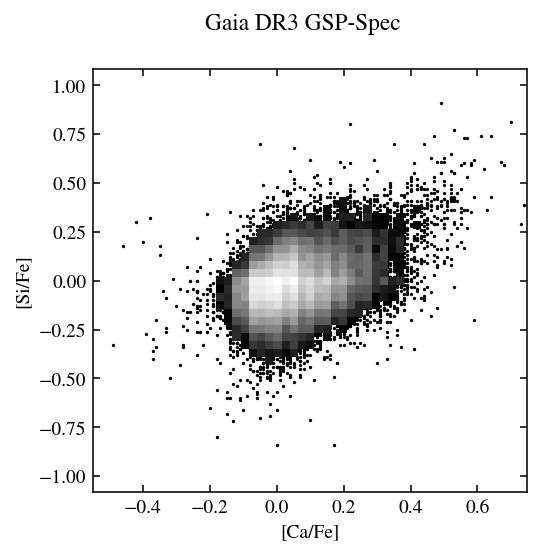

In [10]:
fig, ax = plt.subplots()
scatter_hist(ax, alldata["cafe_gspspec"], alldata["sife_gspspec"],
            xlim=(-0.5, 0.7), ylim=(-1, 1))
ax.set_xlabel("[Ca/Fe]")
ax.set_ylabel("[Si/Fe]")
fig.suptitle("Gaia DR3 GSP-Spec")
plt.show()

Looking into the horizontal lines in the above Teff, logg plots.
Teff=4250, logg=1.5

In [11]:
gridpt = alldata[(alldata["teff_gspspec"] > 4249) & 
                 (alldata["teff_gspspec"] < 4251) &
                 (alldata["logg_gspspec"] > 1.49) & 
                 (alldata["logg_gspspec"] < 1.51)]
gridpt

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,sife_gspspec_lower,sife_gspspec_upper,cafe_gspspec,cafe_gspspec_lower,cafe_gspspec_upper,mgfe_gspspec,mgfe_gspspec_lower,mgfe_gspspec_upper,flags_gspspec,alphafe_gspspec_calib
10,2M00000317+5821383,apo25m,116-04,none,0.013232,58.360649,116.219079,-3.839647,8.206,0.021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01100011000029999999999999999999999999999,NaN
39,2M00001493+5534446,apo25m,NGC7789_btx,none,0.062212,55.579067,115.691312,-6.571265,10.372,0.021,...,NaN,NaN,0.1,0.04,0.16,NaN,NaN,NaN,00000000000019999999900999999999999999999,NaN
86,2M00002903+6403157,apo25m,117+01,none,0.120994,64.054382,117.393251,1.732085,9.043,0.030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000131000019999999999999999999999999999,NaN
124,2M00004072+5714404,apo25m,N7789,none,0.169704,57.244583,116.080233,-4.950229,9.945,0.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000212000029999999999999999999999999999,NaN
128,2M00004297+5739255,apo25m,116-04,none,0.179078,57.657097,116.166372,-4.546713,9.606,0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000031000029999999999999999999999999999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613336,2M23592548+5741219,apo25m,N7789,none,359.856167,57.689442,116.003041,-4.480748,8.256,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01100032000029999999999999999999999999999,NaN
613342,2M23592841+6335256,apo25m,117+01,none,359.868413,63.590454,117.192001,1.299451,10.309,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01100021000029999999999999999999999999999,NaN
613345,2M23593029+5720145,apo25m,116-04,none,359.876209,57.337372,115.942704,-4.827812,10.261,0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000031000029999999999999999999999999999,NaN
613360,2M23593407+6302141,apo25m,117+01,none,359.891977,63.037251,117.091755,0.755300,10.326,0.022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00100031000029999999999999999999999999999,NaN


Most of the stars on this grid point seem to come from the upper RGB, with lower surface gravities and temperatures than the GSP-Spec estimate.

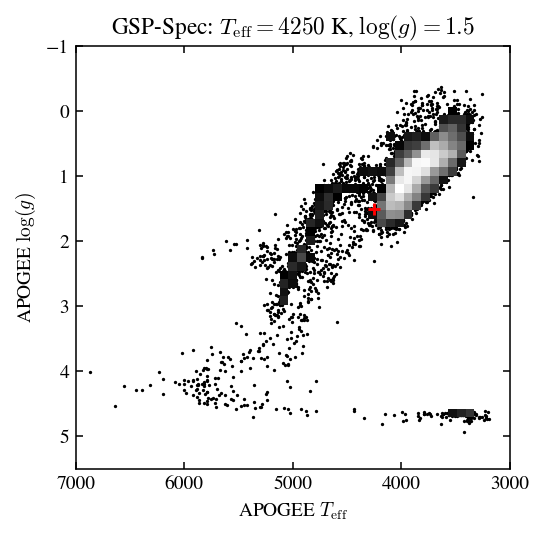

In [12]:
fig, ax = plt.subplots()
scatter_hist(ax, gridpt["TEFF"], gridpt["LOGG"], ylim=(-1, 5.5), xlim=(3000, 7000))
ax.scatter([4250], [1.5], marker='+', c='r')
ax.set_ylim((5.5, -1))
ax.set_xlim((7000, 3000))
ax.set_xlabel(r"APOGEE $T_{\rm{eff}}$")
ax.set_ylabel(r"APOGEE $\log(g)$")
ax.set_title(r'GSP-Spec: $T_{\rm{eff}}=4250$ K, $\log(g)=1.5$')
plt.show()

Recreation of the high-quality sample from the chemical cartography paper

In [124]:
# Select only targets with GSPSpec data
gspspec = alldata[pd.notna(alldata["flags_gspspec"])]
# Same cuts as in Appendix B
hiq = gspspec[(gspspec["teff_gspspec"] > 3500) &
              (gspspec["logg_gspspec"] > 0) &
              (gspspec["logg_gspspec"] < 5) &
              (gspspec["flags_gspspec"].str[:7]=='0000000') &
              (gspspec["flags_gspspec"].str[7].astype(int) < 3) &
              (gspspec["flags_gspspec"].str[12].astype(int) < 2) &
              (gspspec["flags_gspspec"].str[8:12] == '0000')]
hiq

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,cafe_gspspec,cafe_gspspec_lower,cafe_gspspec_upper,mgfe_gspspec,mgfe_gspspec_lower,mgfe_gspspec_upper,flags_gspspec,alphafe_gspspec_calib,alphafe_gspspec_calib_logg,alphafe_gspspec_calib_teff
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,0.23,0.20,0.26,NaN,NaN,NaN,00000001000009999999900990100999999991205,-0.152814,0.002664,0.004522
9,2M00000233+1452324,apo25m,105-45,none,0.009748,14.875667,104.845530,-46.183158,10.649,0.022,...,-0.04,-0.10,0.02,NaN,NaN,NaN,00000000000009999999900999999999999999999,-0.170504,-0.174977,-0.065527
12,2M00000506+5656353,apo25m,NGC7789_btx,none,0.021113,56.943142,115.941040,-5.229802,9.317,0.026,...,0.04,-0.00,0.10,NaN,NaN,NaN,00000000000009999019900999900999999999999,0.090756,0.092591,0.038165
15,2M00000546+6152107,apo25m,116+00,none,0.022759,61.869644,116.918992,-0.401038,9.013,0.063,...,0.10,0.08,0.12,NaN,NaN,NaN,00000001000009999999900009900999999999990,-0.083020,-0.008348,0.015328
24,2M00000866+7122144,apo25m,120+08,none,0.036099,71.370689,118.816522,8.910097,9.795,0.023,...,-0.05,-0.09,-0.01,NaN,NaN,NaN,00000000000009999999900999900999999999999,0.008042,0.004204,-0.046162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613423,2M23595157+5607093,apo25m,NGC7789_MGA,none,359.964912,56.119274,115.745654,-6.030996,9.773,0.022,...,0.08,0.03,0.15,NaN,NaN,NaN,00000000000009999999900999900999999999999,-0.061474,0.008012,0.010513
613431,2M23595453+5618262,apo25m,NGC7789_MGA,none,359.977248,56.307304,115.790143,-5.848118,9.920,0.026,...,0.00,-0.05,0.05,NaN,NaN,NaN,00000000000009999999900999900999999999999,0.021957,0.023509,-0.011552
613435,2M23595490+5704387,apo25m,N7789,none,359.978770,57.077431,115.945170,-5.093610,9.307,0.024,...,-0.03,-0.05,0.01,-0.01,-0.17,0.23,00000000000009922999900019900999999999999,0.022829,0.022509,-0.019680
613444,2M23595606+6251121,apo25m,116+00,none,359.983620,62.853386,117.096010,0.566818,10.875,0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,00000000000009999999999999999999999999999,0.020654,0.064835,-0.034181


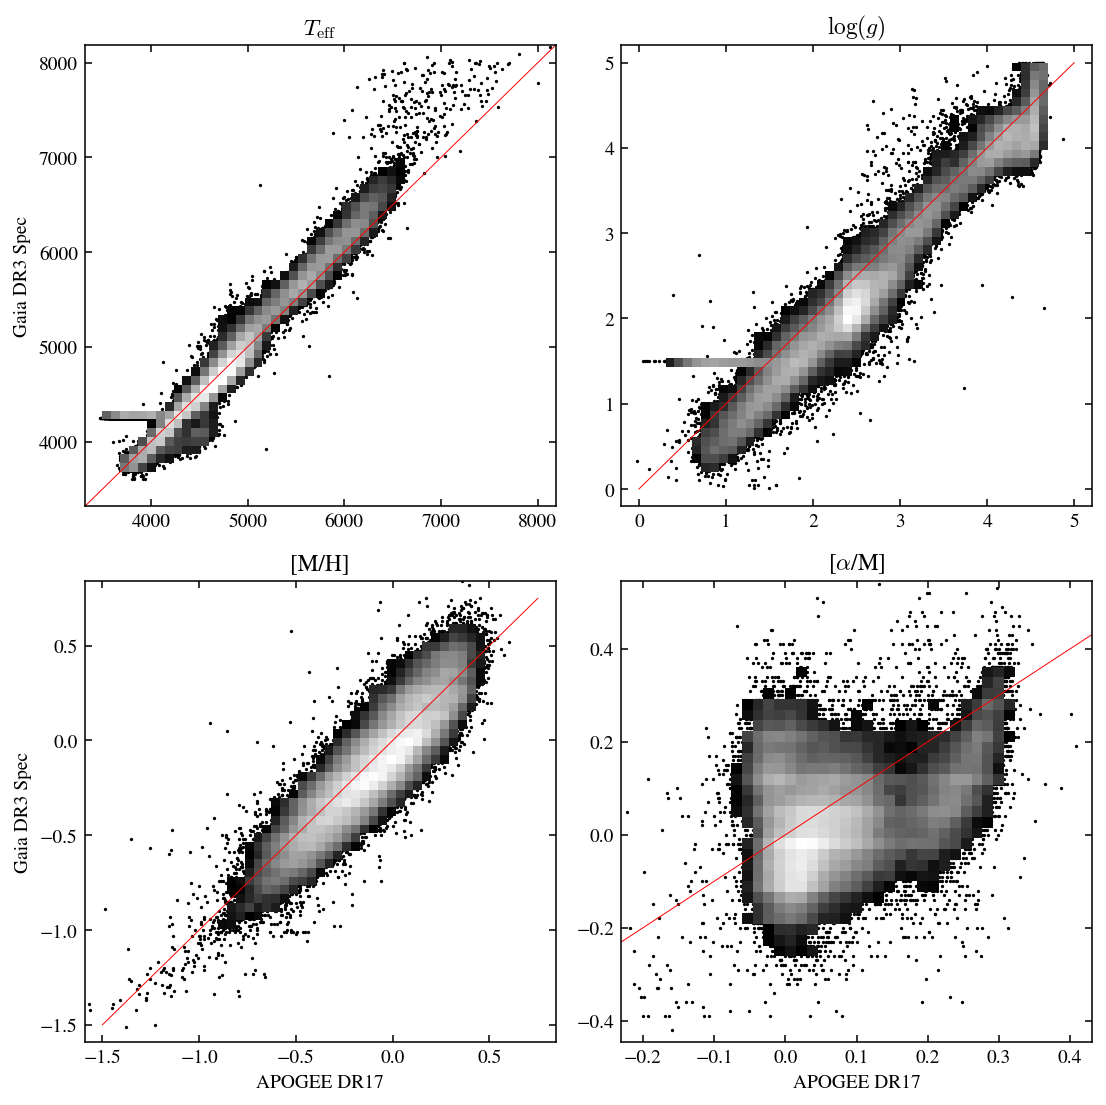

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

scatter_hist(axs[0,0], hiq["TEFF"], hiq["teff_gspspec"], 
             xlim=(3500, 8000), ylim=(3500, 8000))
axs[0,0].plot([3000, 10000], [3000, 10000], c='r', lw=0.5)
axs[0,0].set_title(r"$T_{\rm{eff}}$")
axs[0,0].set_ylabel("Gaia DR3 Spec")

scatter_hist(axs[0,1], hiq["LOGG"], hiq["logg_gspspec"], 
             xlim=(0, 5), ylim=(0, 5))
axs[0,1].plot([0, 5], [0, 5], c='r', lw=0.5)
axs[0,1].set_title(r"$\log(g)$")

scatter_hist(axs[1,0], hiq["M_H"], hiq["mh_gspspec"], 
             xlim=(-1.5, 0.75), ylim=(-1.5, 0.75))
axs[1,0].plot([-1.5, 0.75], [-1.5, 0.75], c='r', lw=0.5)
axs[1,0].set_xlabel("APOGEE DR17")
axs[1,0].set_ylabel("Gaia DR3 Spec")
axs[1,0].set_title("[M/H]")

scatter_hist(axs[1,1], hiq["ALPHA_M"], hiq["alphafe_gspspec"],
             xlim=(-0.2, 0.4), ylim=(-0.4, 0.5), nbins=40)
axs[1,1].plot([-0.5, 1], [-0.5, 1], c='r', lw=0.5)
axs[1,1].set_title(r"[$\alpha$/M]")
axs[1,1].set_xlabel("APOGEE DR17")

plt.show()

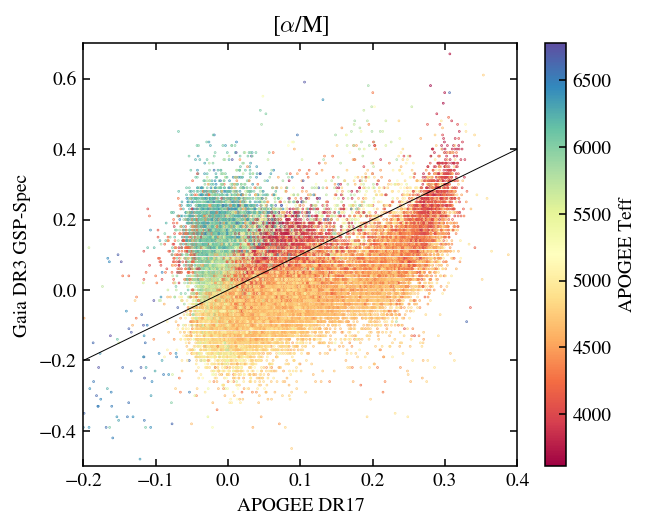

In [27]:
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(hiq["ALPHA_M"], hiq["alphafe_gspspec"], 
                s=0.1, c=hiq["TEFF"], cmap='Spectral')
ax.plot([-0.4, 0.4], [-0.4, 0.4], c='k', linewidth=0.5)
ax.set_xlim((-0.2, 0.4))
ax.set_ylim((-0.5, 0.7))
fig.colorbar(pc, label="APOGEE Teff")
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP-Spec")
ax.set_title(r"[$\alpha$/M]")
plt.show()

In [141]:
diff = hiq['alphafe_gspspec_calib_logg'] - hiq['ALPHA_M']
diff.mean(), diff.median(), diff.std()

(-0.05025526136159897, -0.0450499951839447, 0.08333496749401093)

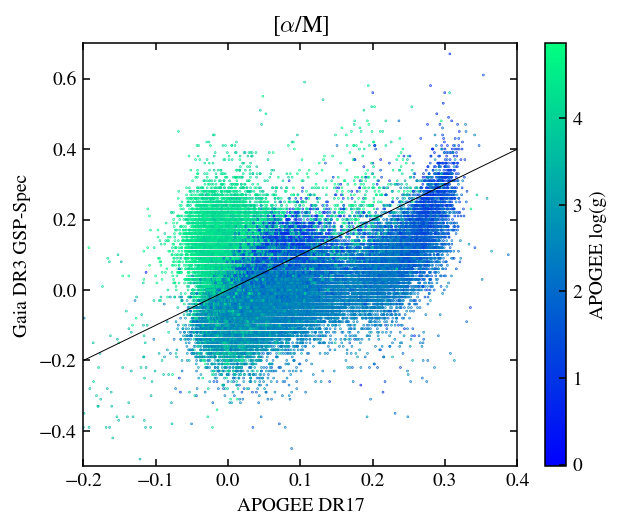

In [30]:
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(hiq["ALPHA_M"], hiq["alphafe_gspspec"], 
                s=0.1, c=hiq["LOGG"], cmap='winter')
ax.plot([-0.4, 0.4], [-0.4, 0.4], c='k', linewidth=0.5)
fig.colorbar(pc, label="APOGEE log(g)")
ax.set_xlim((-0.2, 0.4))
ax.set_ylim((-0.5, 0.7))
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP-Spec")
ax.set_title(r"[$\alpha$/M]")
plt.show()

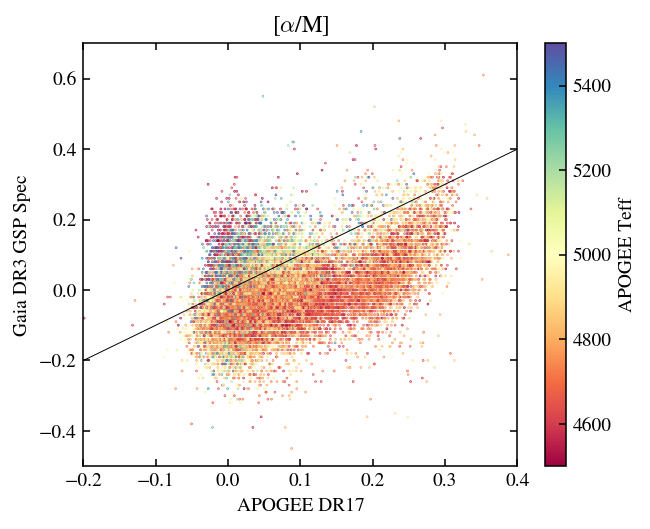

In [31]:
df = hiq[(hiq["TEFF"] > 4500) & (hiq["TEFF"] < 5500)]
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(df["ALPHA_M"], df["alphafe_gspspec"], 
                s=0.1, c=df["TEFF"], cmap='Spectral')
fig.colorbar(pc, label="APOGEE Teff")
ax.plot([-0.4, 0.4], [-0.4, 0.4], c='k', linewidth=0.5)
ax.set_xlim((-0.2, 0.4))
ax.set_ylim((-0.5, 0.7))
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP Spec")
ax.set_title(r"[$\alpha$/M]")
plt.show()

## M67

In [18]:
occam_member = Table.read("data/occam_member-DR17.fits", format="fits")
occam_df = decode(occam_member.to_pandas())
occam_df

,CLUSTER,APOGEE_ID,LOCATION_ID,GLON,GLAT,VHELIO_AVG,VSCATTER,FE_H,FE_H_ERR,PMRA,PMRA_ERR,PMDEC,PMDEC_ERR,RV_PROB,FEH_PROB,PM_PROB,CG_PROB
0,Alessi 57,2M19204583+1541351,5031,50.195928,0.802233,32.87,0.03,0.20,0.01,-3.12,0.06,-3.30,0.06,0.00,0.0,0.00,-9999.99
1,Alessi 57,2M19204998+1540135,5031,50.183748,0.776890,6.33,0.12,0.27,0.01,-1.78,0.03,-4.00,0.03,0.00,0.0,0.00,-9999.99
2,Alessi 57,2M19205008+1540273,5031,50.187298,0.778336,18.72,0.08,-0.04,0.01,-2.13,0.13,-5.57,0.12,1.00,1.0,0.59,-9999.99
3,Alessi 57,2M19205190+1542058,5031,50.214893,0.784750,27.27,0.05,-0.13,0.01,-1.59,0.04,-8.28,0.04,0.00,0.0,0.00,-9999.99
4,Alessi 57,2M19205216+1538195,5031,50.159907,0.754288,-10.81,0.12,-0.29,0.01,2.73,0.01,-6.90,0.02,0.00,0.0,0.00,-9999.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26694,Wit 3,2M07221011-0905413,4582,224.532053,2.602547,118.04,0.05,-0.16,0.01,-0.06,0.01,-0.38,0.01,0.00,0.0,-0.00,-9999.99
26695,Wit 3,2M07221472-0857282,4582,224.419880,2.683599,105.13,0.32,-0.30,0.01,-1.02,0.02,1.07,0.01,0.84,1.0,0.68,-9999.99
26696,Wit 3,2M07222253-0901403,4582,224.496900,2.679103,58.86,3.59,-0.09,0.01,-1.64,0.01,2.40,0.01,0.00,0.0,-0.00,-9999.99
26697,Wit 3,2M07222909-0856255,4582,224.432306,2.743977,84.05,0.43,0.11,0.01,-0.31,0.01,-5.61,0.01,0.00,0.0,-0.00,-9999.99


In [19]:
M67_members = occam_df[(occam_df["CLUSTER"] == "NGC 2682") &
                       (occam_df["CG_PROB"] > 0.5)]
M67_members

,CLUSTER,APOGEE_ID,LOCATION_ID,GLON,GLAT,VHELIO_AVG,VSCATTER,FE_H,FE_H_ERR,PMRA,PMRA_ERR,PMDEC,PMDEC_ERR,RV_PROB,FEH_PROB,PM_PROB,CG_PROB
22458,NGC 2682,2M08492379+1154367,7252,215.349595,31.519294,34.42,0.10,-0.02,0.01,-10.91,0.03,-3.10,0.03,0.98,0.86,0.61,0.7
22460,NGC 2682,2M08492491+1144057,5115,215.538531,31.450138,26.64,5.65,0.06,0.01,-10.98,0.03,-2.79,0.02,0.00,0.35,0.85,0.7
22461,NGC 2682,2M08492523+1145558,7252,215.506638,31.464151,35.08,4.10,-0.03,0.01,-10.73,0.04,-2.91,0.03,0.76,0.77,0.55,0.7
22463,NGC 2682,2M08492885+1140082,6227,215.616640,31.437078,57.63,0.00,0.01,0.01,-10.81,0.03,-2.54,0.03,0.00,0.97,0.14,0.6
22484,NGC 2682,2M08494490+1141562,5115,215.616927,31.509134,35.63,3.17,-0.05,0.01,-10.76,0.04,-3.11,0.03,0.48,0.50,0.39,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23056,NGC 2682,2M08524441+1149029,6294,215.851483,32.223660,NaN,0.00,NaN,NaN,-10.65,0.04,-2.70,0.03,NaN,NaN,0.18,0.7
23057,NGC 2682,2M08524464+1138414,7252,216.037123,32.152098,34.09,0.19,0.04,0.01,-11.03,0.05,-2.61,0.04,1.00,0.61,0.31,0.6
23058,NGC 2682,2M08524511+1147157,7252,215.884871,32.213776,34.98,0.13,-0.14,0.01,-11.46,0.06,-3.34,0.04,0.80,0.00,0.01,0.6
23069,NGC 2682,2M08525625+1148539,6294,215.878078,32.266448,33.13,0.00,0.08,0.01,-11.14,0.02,-2.98,0.01,0.67,0.13,0.63,0.6


In [75]:
M67 = alldata.set_index("APOGEE_ID").join(M67_members.set_index("APOGEE_ID"), how="inner", rsuffix="_OCCAM")
M67.shape

(319, 272)

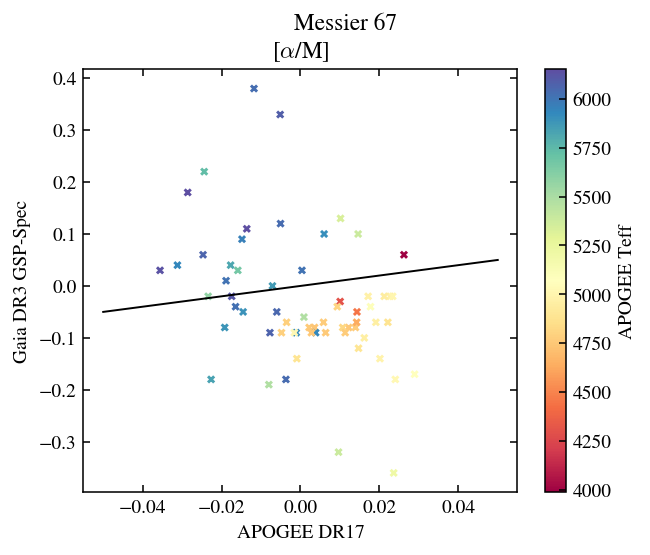

In [32]:
fig, ax = plt.subplots(dpi=140, figsize=(5, 4))
pc = ax.scatter(M67["ALPHA_M"], M67["alphafe_gspspec"], 
                c=M67["TEFF"], s=10, marker='x', cmap='Spectral')
fig.colorbar(pc, label="APOGEE Teff")
ax.plot([-0.05, 0.05], [-0.05, 0.05], c='k', linewidth=1)
ax.set_xlabel("APOGEE DR17")
ax.set_ylabel("Gaia DR3 GSP-Spec")
ax.set_title(r"[$\alpha$/M]")
fig.suptitle("Messier 67")
plt.show()

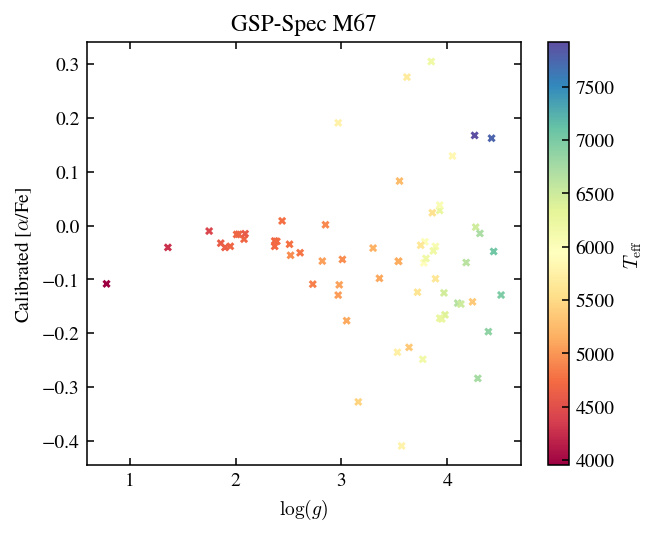

In [150]:
fig, ax = plt.subplots(figsize=(5, 4))
pc = ax.scatter(M67['logg_gspspec'], M67['alphafe_gspspec_calib_logg'],
               marker='x', s=10, c=M67['teff_gspspec'], cmap='Spectral')
fig.colorbar(pc, label=r'$T_{\rm{eff}}$')
ax.set_xlabel(r'$\log(g)$')
ax.set_ylabel(r'Calibrated [$\alpha$/Fe]')
ax.set_title('GSP-Spec M67')
plt.show()

In [38]:
M67[(pd.notna(M67['alphafe_gspspec'])) & 
    (pd.isna(M67['ALPHA_M']))]

,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,...,FE_H_OCCAM,FE_H_ERR_OCCAM,PMRA,PMRA_ERR,PMDEC,PMDEC_ERR,RV_PROB,FEH_PROB,PM_PROB,CG_PROB
APOGEE_ID,,,,,,,,,,,,,,,,,,,,,
2M08512643+1143506,lco25m,M67-S,none,132.860128,11.730746,215.787129,31.898497,11.020,0.021,11.011,...,NaN,NaN,-11.09,0.03,-2.58,0.02,0.97,NaN,0.22,0.9
2M08513259+1148520,lco25m,M67-S,none,132.885801,11.814464,215.709968,31.956391,10.645,0.022,10.541,...,NaN,NaN,-11.18,0.02,-3.11,0.02,1.00,NaN,0.34,0.9


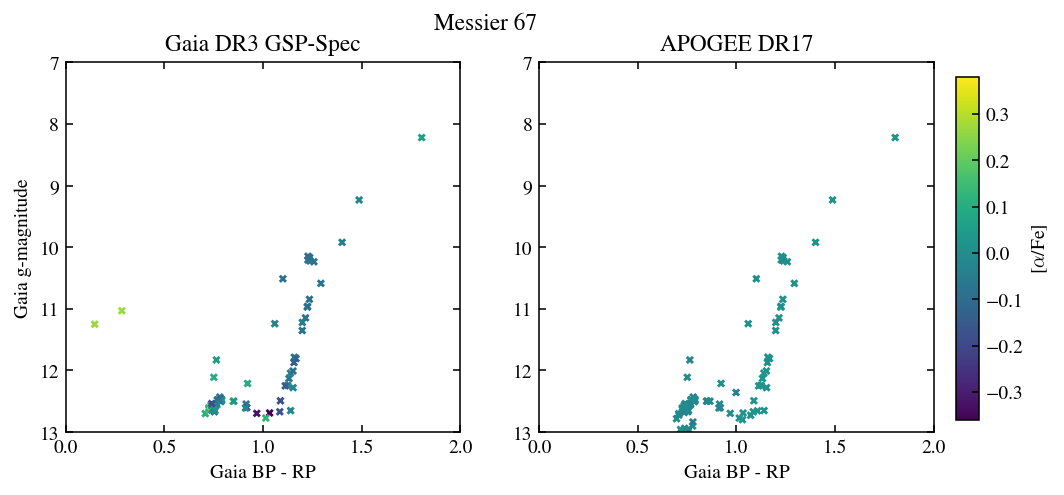

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), dpi=140)

ms = 10

# colorbar
fig.subplots_adjust(right=0.9)
cax = plt.axes([0.92, 0.15, 0.02, 0.7])

pc = axs[0].scatter(M67['bp_rp'], M67['phot_g_mean_mag'], 
               c=M67['alphafe_gspspec'], s=ms, marker='x')
cbar = fig.colorbar(pc, cax, label=r'[$\alpha$/Fe]')
axs[0].set_ylim((13, 7))
axs[0].set_xlim((0, 2))
axs[0].set_xlabel('Gaia BP - RP')
axs[0].set_ylabel('Gaia g-magnitude')
axs[0].set_title('Gaia DR3 GSP-Spec')

axs[1].scatter(M67['bp_rp'], M67['phot_g_mean_mag'], 
               c=M67['ALPHA_M'], s=ms, cmap=cbar.cmap, 
               norm=cbar.norm, marker='x')
axs[1].set_ylim((13, 7))
axs[1].set_xlim((0, 2))
axs[1].set_xlabel('Gaia BP - RP')
axs[1].set_title('APOGEE DR17')

fig.suptitle('Messier 67')
plt.show()

Calibrated plots

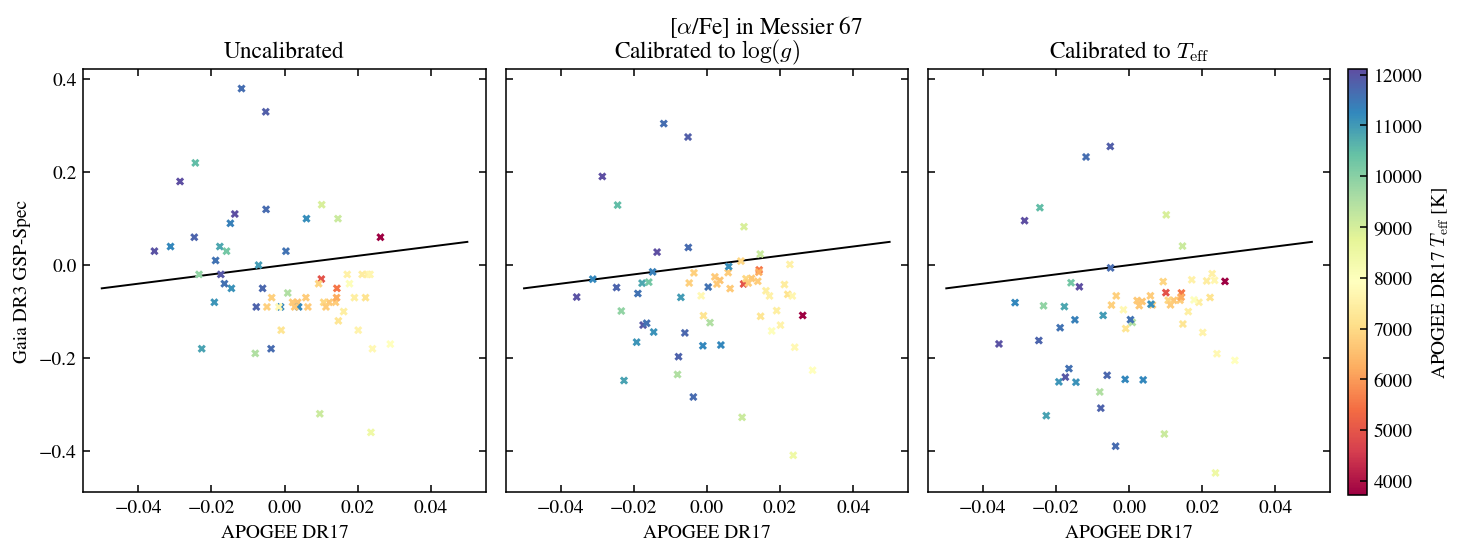

In [104]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharex=True, sharey=True)
fig.subplots_adjust(right=0.81, wspace=0.05)
cax = plt.axes([0.82, 0.12, 0.01, 0.76])
norm = colors.Normalize(vmin=M67['TEFF'].min(), vmax=M67['TEFF'].max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Spectral'), 
                    cax=cax, label=r'APOGEE DR17 $T_{\rm{eff}}$ [K]')

# Uncalibrated
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], c='k', linewidth=1, zorder=0)
pc = axs[0].scatter(M67["ALPHA_M"], M67["alphafe_gspspec"], 
                    c=M67["TEFF"], s=10, marker='x', cmap='Spectral')
axs[0].set_xlabel("APOGEE DR17")
axs[0].set_ylabel("Gaia DR3 GSP-Spec")
axs[0].set_title("Uncalibrated")

# Calibrated to log(g)
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], c='k', linewidth=1, zorder=0)
pc = axs[1].scatter(M67["ALPHA_M"], M67["alphafe_gspspec_calib_logg"], 
                    c=M67["TEFF"], s=10, marker='x', cmap='Spectral')
axs[1].set_xlabel("APOGEE DR17")
axs[1].set_title(r"Calibrated to $\log(g)$")


# Calibrated to Teff
axs[2].plot([-0.05, 0.05], [-0.05, 0.05], c='k', linewidth=1, zorder=0)
pc = axs[2].scatter(M67["ALPHA_M"], M67["alphafe_gspspec_calib_teff"], 
                    c=M67["TEFF"], s=10, marker='x', cmap='Spectral')
axs[2].set_xlabel("APOGEE DR17")
axs[2].set_title(r"Calibrated to $T_{\rm{eff}}$")

fig.suptitle(r"[$\alpha$/Fe] in Messier 67")
plt.show()

Calibration to $\log(g)$ seems to yield an improvement over the uncalibrated abundances, whereas calibration to $T_{\rm{eff}}$ doesn't seem to offer big improvements.

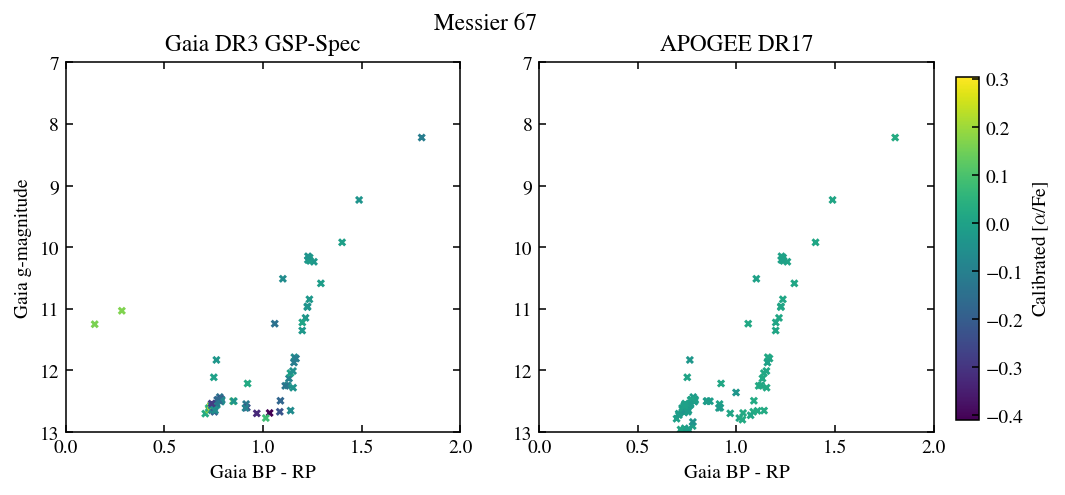

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), dpi=140)

ms = 10

# colorbar
fig.subplots_adjust(right=0.9)
cax = plt.axes([0.92, 0.15, 0.02, 0.7])

pc = axs[0].scatter(M67['bp_rp'], M67['phot_g_mean_mag'], 
               c=M67['alphafe_gspspec_calib_logg'], s=ms, marker='x')
cbar = fig.colorbar(pc, cax, label=r'Calibrated [$\alpha$/Fe]')
axs[0].set_ylim((13, 7))
axs[0].set_xlim((0, 2))
axs[0].set_xlabel('Gaia BP - RP')
axs[0].set_ylabel('Gaia g-magnitude')
axs[0].set_title('Gaia DR3 GSP-Spec')

axs[1].scatter(M67['bp_rp'], M67['phot_g_mean_mag'], 
               c=M67['ALPHA_M'], s=ms, cmap=cbar.cmap, 
               norm=cbar.norm, marker='x')
axs[1].set_ylim((13, 7))
axs[1].set_xlim((0, 2))
axs[1].set_xlabel('Gaia BP - RP')
axs[1].set_title('APOGEE DR17')

fig.suptitle('Messier 67')
plt.show()

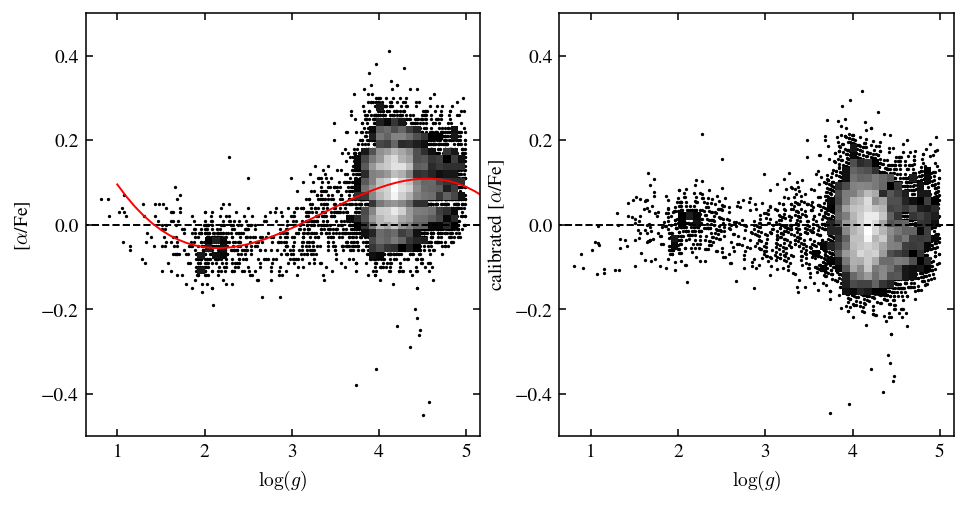

In [65]:
# test [alpha/Fe] calibration
solar = hiq[(1/hiq["parallax"] < 0.25) &
                (hiq["mh_gspspec"] > -0.25) &
                (hiq["mh_gspspec"] < 0.25)]
xarr = np.arange(1, 6, 0.1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
scatter_hist(axs[0], solar["logg_gspspec"], solar["alphafe_gspspec"])
axs[0].plot([0, 7], [0, 0], c='k', lw=1, ls='--')
axs[0].plot(xarr, [-logg_calib(x) for x in xarr], c='r', lw=1)
axs[0].set_ylim((-0.5, 0.5))
axs[0].set_xlabel(r"$\log(g)$")
axs[0].set_ylabel(r"[$\alpha$/Fe]")
# scatter_hist(axs[1], solar["logg_gspspec"], solar["alphafe_gspspec_calib"])
scatter_hist(axs[1], solar["logg_gspspec"], solar["alphafe_gspspec"] + logg_calib(solar["logg_gspspec"]))
axs[1].plot([0, 7], [0, 0], c='k', lw=1, ls='--')
axs[1].set_ylim((-0.5, 0.5))
axs[1].set_xlabel(r"$\log(g)$")
axs[1].set_ylabel(r"calibrated [$\alpha$/Fe]")
plt.show()

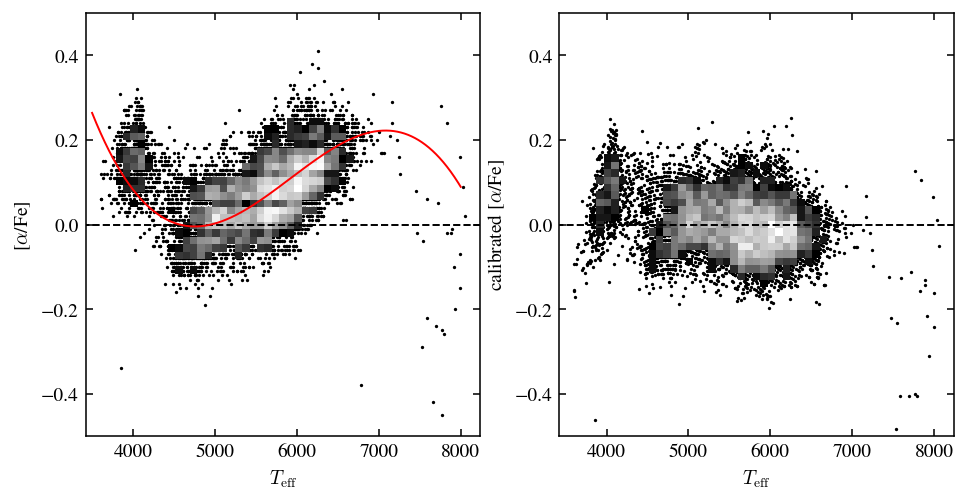

In [67]:
xarr = np.arange(3500, 8000, 0.1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
scatter_hist(axs[0], solar["teff_gspspec"], solar["alphafe_gspspec"])
axs[0].plot([2500, 9000], [0, 0], c='k', lw=1, ls='--')
axs[0].plot(xarr, [-teff_calib(x/5750) for x in xarr], c='r', lw=1)
axs[0].set_ylim((-0.5, 0.5))
axs[0].set_xlabel(r"$T_{\rm{eff}}$")
axs[0].set_ylabel(r"[$\alpha$/Fe]")
# scatter_hist(axs[1], solar["teff_gspspec"], solar["alphafe_gspspec_calib"])
scatter_hist(axs[1], solar["teff_gspspec"], solar["alphafe_gspspec"] + teff_calib(solar["teff_gspspec"]/5750))
axs[1].plot([2500, 9000], [0, 0], c='k', lw=1, ls='--')
axs[1].set_ylim((-0.5, 0.5))
axs[1].set_xlabel(r"$T_{\rm{eff}}$")
axs[1].set_ylabel(r"calibrated [$\alpha$/Fe]")
plt.show()

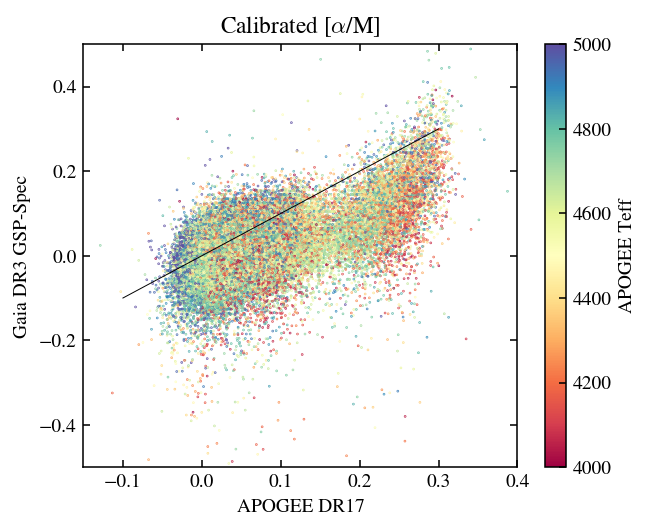

In [144]:
hiq_rgb = hiq[(hiq['logg_gspspec'] < 3) & (hiq['teff_gspspec'] < 5000) & (hiq['teff_gspspec'] > 4000)]
fig, ax = plt.subplots(figsize=(5, 4))
pc = ax.scatter(hiq_rgb['ALPHA_M'], hiq_rgb['alphafe_gspspec_calib_logg'], 
                s=0.1, c=hiq_rgb['TEFF'], cmap='Spectral', 
                norm=colors.Normalize(vmin=4000, vmax=5000))
ax.plot([-0.1, 0.3], [-0.1, 0.3], c='k', linewidth=0.5)
ax.set_xlim((-0.15, 0.4))
ax.set_ylim((-0.5, 0.5))
fig.colorbar(pc, label='APOGEE Teff')
ax.set_xlabel('APOGEE DR17')
ax.set_ylabel('Gaia DR3 GSP-Spec')
ax.set_title(r'Calibrated [$\alpha$/M]')
plt.show()

In [139]:
diff = hiq_rgb['alphafe_gspspec_calib_logg'] - hiq_rgb['ALPHA_M']
diff.mean(), diff.median(), diff.std()

(-0.04583071544766426, -0.03894741088151932, 0.06808226555585861)